# Modelo MLP para Previsão de Preços de Criptomoedas

## Importação das Bibliotecas

In [520]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, PReLU
from tensorflow.keras.optimizers import Adam, Adamax, AdamW, Lion,RMSprop
import joblib

## PASSO 1: Carregar e Preparar os Dados

**Objetivo:** Ler o arquivo CSV e garantir que ele esteja em ordem.

In [521]:
# Carrega os dados do arquivo CSV
df = pd.read_csv(r"C:\Users\david\Desktop\trading-algoritmico\data\fechamentos\SOLUSDT_15m_data.csv")

# Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df = df.reset_index(drop=True)

# Remove colunas com nomes "Unnamed".
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(f"Dados carregados: {df.shape[0]} registros.")
print(df.head())

Dados carregados: 70080 registros.
            timestamp   open   high    low  close     volume
0 2023-07-20 15:30:00  26.20  26.21  25.75  25.91  121467.56
1 2023-07-20 15:45:00  25.90  25.91  25.57  25.69  191787.08
2 2023-07-20 16:00:00  25.69  25.77  25.56  25.66  106474.05
3 2023-07-20 16:15:00  25.67  25.67  25.21  25.37  170476.73
4 2023-07-20 16:30:00  25.38  25.47  25.33  25.42   75885.50


## PASSO 2: Preparar os Dados para o Modelo

**Objetivo:** Transformar os dados brutos em um formato que a rede neural entenda (features e target).

In [522]:
# --- Calculo dos Indicadores ---
# Calcula as variações percentuais de 'close' e 'volume'
df['close_pct'] = df['close'].pct_change()
df['volume_pct'] = df['volume'].pct_change()

# Calcula a média móvel simples de 10 e 30 períodos para 'close'
df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_30'] = df['close'].rolling(window=30).mean()

# Calcula o Índice de Força Relativa (RSI) de 14 períodos
def rsi(series, period=14):
    gain = (series.where(series > 0, 0)).rolling(window=period).mean()
    loss = (-series.where(series < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
df['rsi_7'] = rsi(df['close'], period=7)
df['rsi_14'] = rsi(df['close'], period=14)
df['rsi_21'] = rsi(df['close'], period=21)

# Calcula o MACD
def macd(series, short_window=12, long_window=26, signal_window=9):
    exp1 = series.ewm(span=short_window, adjust=False).mean()
    exp2 = series.ewm(span=long_window, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line
df['macd'], df['macd_signal'] = macd(df['close'])

# Calcula o Bollinger Bands
def bollinger_bands(series, window=20, num_std_dev=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band
df['bb_upper'], df['bb_lower'] = bollinger_bands(df['close'])

# Calcula o desvio padrão de 10, 20 e 40 períodos
df['std_10'] = df['close'].rolling(window=10).std()
df['std_20'] = df['close'].rolling(window=20).std()
df['std_40'] = df['close'].rolling(window=40).std()

# Calcula a média móvel exponencial de 10 e 30 períodos
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calcula indicadores lagging
df['lag_close_pct_1'] = df['close_pct'].shift(1)  # Preço de fechamento do período anterior
df['lag_close_pct_2'] = df['close_pct'].shift(2)  # Preço de fechamento de dois períodos atrás

df['lag_rsi_7_1'] = df['rsi_7'].shift(1)  # RSI do período anterior
df['lag_rsi_7_2'] = df['rsi_7'].shift(2)  # RSI de dois períodos atrás

df['lag_rsi_14_1'] = df['rsi_14'].shift(1)  # RSI de 14 períodos do período anterior
df['lag_rsi_14_2'] = df['rsi_14'].shift(2)  # RSI de 14 períodos de dois períodos atrás

df['lag_rsi_21_1'] = df['rsi_21'].shift(1)  # RSI de 21 períodos do período anterior
df['lag_rsi_21_2'] = df['rsi_21'].shift(2)  # RSI de 21 períodos de dois períodos atrás

df['lag_macd_1'] = df['macd'].shift(1)  # MACD do período anterior
df['lag_macd_2'] = df['macd'].shift(2)  # MACD de dois períodos atrás

df['lag_macd_signal_1'] = df['macd_signal'].shift(1)  # Sinal do MACD do período anterior
df['lag_macd_signal_2'] = df['macd_signal'].shift(2)  # Sinal do MACD de dois períodos atrás

# Distância do preço atual para a média móvel (mostra se está sobrecomprado/sobrevendido)
df['price_vs_sma30'] = df['close'] - df['sma_30']

# Cruzamento de médias móveis (um forte indicador de tendência)
df['sma_10_vs_sma_30'] = df['sma_10'] - df['sma_30']

# Diferença do MACD para a sua linha de sinal
df['macd_diff'] = df['macd'] - df['macd_signal']

# Volatilidade (desvio padrão dos retornos logarítmicos)
df['volatility_10'] = df['close'].pct_change().rolling(window=10).std()
df['volatility_20'] = df['close'].pct_change().rolling(window=20).std()
df['volatility_40'] = df['close'].pct_change().rolling(window=40).std()

# Apaga as linhas com valores NaN
df = df.dropna()
df = df.reset_index(drop=True)


In [523]:
# --- Definição das Variáveis ---
FEATURE_COLUMNS = ['close_pct', 'volume_pct', 'sma_10', 'sma_30', 'rsi_7', 'rsi_14', 'rsi_21','macd', 'macd_signal', 
                   'bb_upper', 'bb_lower', 'std_10', 'std_20', 'std_40', 'ema_10', 'ema_30',
                   'lag_close_pct_1', 'lag_close_pct_2', 'lag_rsi_7_1', 'lag_rsi_7_2', 'lag_rsi_14_1', 'lag_rsi_14_2', 'lag_rsi_21_1', 'lag_rsi_21_2',
                   'lag_macd_1', 'lag_macd_2', 'lag_macd_signal_1', 'lag_macd_signal_2',
                   'price_vs_sma30', 'sma_10_vs_sma_30', 'macd_diff', 'volatility_10', 'volatility_20','volatility_40']
TARGET_COLUMN = 'close'

# SEQUENCE_LENGTH: Quantos períodos olharemos para trás para prever o próximo
SEQUENCE_LENGTH = 16

# --- Criação das Features (X) e do Alvo (y) ---
# O alvo (y) será binário: 1 se o preço subir, 0 se não
# df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período
y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

# As features (X) serão os dados da FEATURE_COLUMNS
X_raw = df[FEATURE_COLUMNS]

print(f"Features definidas: {FEATURE_COLUMNS}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Shape dos dados brutos: {X_raw.shape}")

Features definidas: ['close_pct', 'volume_pct', 'sma_10', 'sma_30', 'rsi_7', 'rsi_14', 'rsi_21', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'std_10', 'std_20', 'std_40', 'ema_10', 'ema_30', 'lag_close_pct_1', 'lag_close_pct_2', 'lag_rsi_7_1', 'lag_rsi_7_2', 'lag_rsi_14_1', 'lag_rsi_14_2', 'lag_rsi_21_1', 'lag_rsi_21_2', 'lag_macd_1', 'lag_macd_2', 'lag_macd_signal_1', 'lag_macd_signal_2', 'price_vs_sma30', 'sma_10_vs_sma_30', 'macd_diff', 'volatility_10', 'volatility_20', 'volatility_40']
Sequence length: 16
Shape dos dados brutos: (70040, 34)


In [524]:
# --- Normalização dos Dados ---
# Importante para redes neurais, pois ajuda na convergência do modelo
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=100)
X_scaled = scaler.fit_transform(X_raw)

print(f"Dados normalizados. Shape: {X_scaled.shape}")
print(f"Min: {X_scaled.min()}, Max: {X_scaled.max()}")

Dados normalizados. Shape: (70040, 34)
Min: -5.199337582605575, Max: 5.19933758270342


In [525]:
# --- Criação das Sequências ---
# Cria sequências de dados para o modelo
X_sequences, y_sequences = [], []
for i in range(len(X_scaled) - SEQUENCE_LENGTH):
    X_sequences.append(X_scaled[i : i + SEQUENCE_LENGTH])
    y_sequences.append(y[i + SEQUENCE_LENGTH -1]) # O alvo corresponde ao final da sequência

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")

Sequências criadas. X shape: (70024, 16, 34), y shape: (70024,)


In [526]:
# --- Reshape do X para o MLP ---
# O MLP espera uma entrada 2D, então precisa achatar as sequências
num_samples = X.shape[0]
num_features_flat = X.shape[1] * X.shape[2]
X = X.reshape(num_samples, num_features_flat)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (alvo): {y.shape}")

Shape de X (features): (70024, 544)
Shape de y (alvo): (70024,)


In [527]:
# --- Divisão em Treino e Teste ---
# Divisão dos dados em treino e teste
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Tentativa de balancear as classes, evitando a mesma reposta sempre
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Amostras de treino: {len(X_train)}")
print(f"Amostras de teste: {len(X_test)}")
print(f"Distribuição do target no treino: {np.bincount(y_train)}")
print(f"Distribuição do target no teste: {np.bincount(y_test)}")

Amostras de treino: 56019
Amostras de teste: 14005
Distribuição do target no treino: [28309 27710]
Distribuição do target no teste: [7016 6989]


## PASSO 3: Construir o Modelo (MLP)

**Objetivo:** Definir a arquitetura da nossa rede neural.

In [528]:
model = Sequential()

# Camada de Entrada: Define o formato da nossa entrada
model.add(Input(shape=(num_features_flat,)))

# 1ª Camada Oculta: Primeira camada que aprende os padrões
model.add(Dense(units=256))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())  

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.3))

# 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
model.add(Dense(units=128))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.3))

# 3ª Camada Oculta: Terceira camada para aprender padrões mais complexos
model.add(Dense(units=64))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.3))

# Camada de Saída: Gera a previsão final
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# --- Compilação do Modelo ---
# O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ (None, 256)            │       139,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_63 (PReLU)              │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_64 (PReLU)              │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_65 (PReLU)              │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,185 (707.75 KB)

 Trainable params: 181,185 (707.75 KB)

 Non-trainable params: 0 (0.00 B)

## PASSO 4: Treinar o Modelo

**Objetivo:** Alimentar o modelo com os dados de treino para que ele aprenda.

In [530]:
# Callbacks para otimizar o treinamento 
callbacks = [ 
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)]

history = model.fit(
    X_train,
    y_train,
    epochs=200,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
    batch_size=64,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
    validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
    class_weight=class_weight_dict,  # Pesos das classes para lidar com desbalanceamento
    callbacks=callbacks,  # Callbacks para otimização do treinamento
    verbose=1 # Mostra uma barra de progresso.
)

Epoch 1/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5012 - loss: 8.8922 - val_accuracy: 0.5016 - val_loss: 0.6933 - learning_rate: 0.0500
Epoch 2/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5056 - loss: 2074.1472 - val_accuracy: 0.5010 - val_loss: 20.4770 - learning_rate: 0.0500
Epoch 3/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4976 - loss: 49.6548 - val_accuracy: 0.5007 - val_loss: 14.6864 - learning_rate: 0.0500
Epoch 4/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4988 - loss: 13.5638 - val_accuracy: 0.4990 - val_loss: 1.1911 - learning_rate: 0.0500
Epoch 5/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4993 - loss: 7.0056 - val_accuracy: 0.4990 - val_loss: 3.9241 - learning_rate: 0.0500
Epoch 6/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4982 - loss: 3.1280 - val_accuracy: 0.5010 - val_loss: 0.7591 - learning_rate: 0.0500
Epoch 7/200
876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5038 - l

## PASSO 5: Avaliar o Modelo

**Objetivo:** Verificar o quão bem o modelo se saiu nos dados de teste.

In [531]:
# Fazer previsões nos dados de teste. A saída será uma probabilidade
probabilities = model.predict(X_test)

# Converter probabilidades em classes (0 ou 1) usando um limiar de 0.5
predictions = (probabilities > 0.5).astype(int)

print(probabilities)
# Calcular e mostrar as métricas
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions, target_names=['Não Sobe', 'Sobe'])

print(f"Acurácia no Teste: {accuracy * 100:.2f}%")
print("\nRelatório de Classificação:")
print(report)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
[[0.48764816]
 [0.4875958 ]
 [0.48750854]
 ...
 [0.48737007]
 [0.48820195]
 [0.48853618]]
Acurácia no Teste: 50.16%

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Sobe       0.50      0.99      0.67      7016
        Sobe       0.55      0.01      0.01      6989

    accuracy                           0.50     14005
   macro avg       0.53      0.50      0.34     14005
weighted avg       0.53      0.50      0.34     14005




Matriz de Confusão:


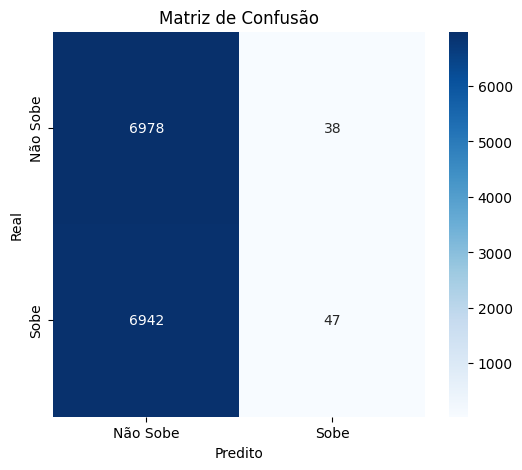

In [532]:
print("\nMatriz de Confusão:")
# Um mapa de calor para visualizar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## PASSO 6: Visualizar o Treinamento

**Objetivo:** Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.

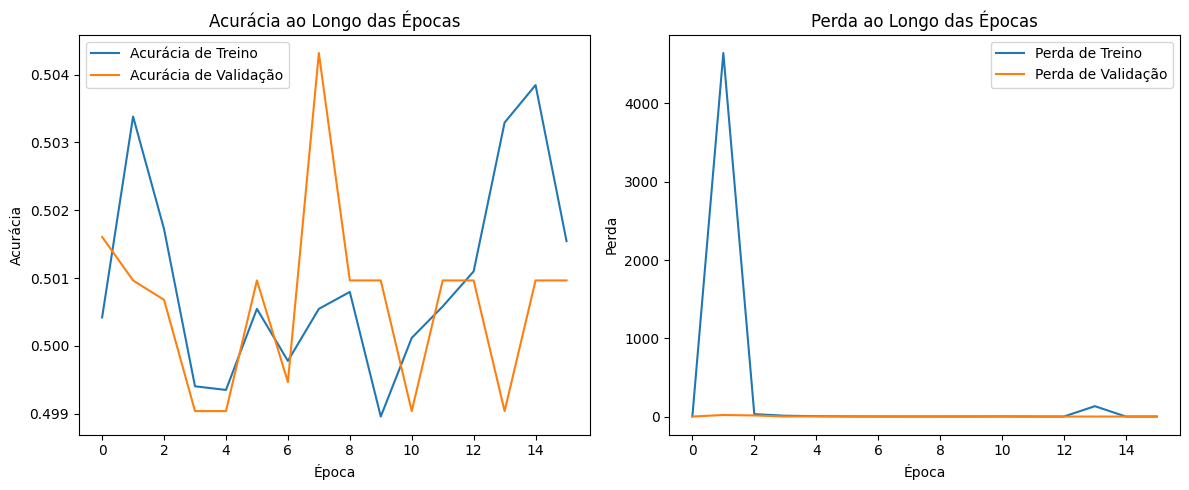

In [533]:
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

## PASSO 7: Salvar o Modelo

**Objetivo:** Salvar o modelo treinado e o normalizador para uso futuro.

In [534]:
# Por enquanto não é necessário salvar o modelo
'''
MODEL_PATH = "mlp_basic_model.h5"
SCALER_PATH = "basic_scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"Modelo salvo em: {MODEL_PATH}")
print(f"Normalizador salvo em: {SCALER_PATH}")
'''

'\nMODEL_PATH = "mlp_basic_model.h5"\nSCALER_PATH = "basic_scaler.pkl"\n\nmodel.save(MODEL_PATH)\njoblib.dump(scaler, SCALER_PATH)\n\nprint(f"Modelo salvo em: {MODEL_PATH}")\nprint(f"Normalizador salvo em: {SCALER_PATH}")\n'

## Conclusão

### Já integrado:

1. **Carrega dados históricos**
2. **Prepara os dados**
3. **Constrói um MLP**
4. **Treina o modelo**
5. **Avalia o desempenho**
6. **Visualiza o treinamento**
7. **Salva o modelo**

### Próximos Passos:
- ENTENDER POR QUE O MODELO SÓ FALA QUE VAI SUBIR (ERA POR CAUSA DO MINMAXSCALER, POR TER MUITOS OUTLIERS ELE APERTAVA VALORES INTERMEDIARIOS EM UM INTERVALO MUITO PEQUENO... TROQUEI PARA STANDARDSCALER)
- Adicionar features técnicas, prepara-las e dar ao treino do modelo
- Implementar validação cruzada temporal
- Testar diferentes janelas temporais

# Testes com outros modelos

**Meio freestyle considerando que os dados são reciclados e não adaptados**

In [539]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com HistGradientBoosting ---")

# Crie e treine o modelo
rf_model = HistGradientBoostingClassifier(max_iter=100, random_state=42)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do HistGradientBoosting:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com HistGradientBoosting ---

Relatório de Classificação do HistGradientBoosting:
              precision    recall  f1-score   support

    Não Sobe       0.52      0.51      0.51      7016
        Sobe       0.51      0.51      0.51      6989

    accuracy                           0.51     14005
   macro avg       0.51      0.51      0.51     14005
weighted avg       0.51      0.51      0.51     14005



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com RandomForest ---")

# Crie e treine o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do RandomForest:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com RandomForest ---

Relatório de Classificação do RandomForest:
              precision    recall  f1-score   support

    Não Sobe       0.51      0.53      0.52      7016
        Sobe       0.51      0.48      0.49      6989

    accuracy                           0.51     14005
   macro avg       0.51      0.51      0.51     14005
weighted avg       0.51      0.51      0.51     14005



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com GradientBoosting ---")

# Crie e treine o modelo
rf_model = GradientBoostingClassifier(
    n_estimators=200,         # Mais árvores pode melhorar, mas aumenta o tempo de treino
    learning_rate=0.05,       # Menor learning_rate pode melhorar generalização, mas exige mais árvores
    max_depth=4,              # Profundidade das árvores (3-5 é comum)
    subsample=0.8,            # Amostragem estocástica para robustez (0.8 é um bom começo)
    max_features='sqrt',      # Considera sqrt(n_features) em cada split (ajuda a evitar overfitting)
    random_state=42
)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do GradientBoosting:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com GradientBoosting ---

Relatório de Classificação do GradientBoosting:
              precision    recall  f1-score   support

    Não Sobe       0.52      0.52      0.52      7016
        Sobe       0.52      0.51      0.51      6989

    accuracy                           0.52     14005
   macro avg       0.52      0.52      0.52     14005
weighted avg       0.52      0.52      0.52     14005



In [538]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

print("--- Executando Testes alternativos com StackingClassifier ---")

# Crie e treine o modelo
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    ))
]

rf_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced'),
    n_jobs=-1,
    passthrough=False
)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do StackingClassifier:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com GradientBoosting ---

Relatório de Classificação do StackingClassifier:
              precision    recall  f1-score   support

    Não Sobe       0.50      0.51      0.50      7016
        Sobe       0.50      0.49      0.49      6989

    accuracy                           0.50     14005
   macro avg       0.50      0.50      0.50     14005
weighted avg       0.50      0.50      0.50     14005



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com ExtraTreesClassifier ---")

# Crie e treine o modelo
rf_model = ExtraTreesClassifier(
    n_estimators=200,         # Número de árvores na floresta
    max_depth=6,              # Profundidade máxima das árvores (ajuda a evitar overfitting)
    max_features='sqrt',      # Número de features consideradas em cada split
    min_samples_split=5,      # Mínimo de amostras para dividir um nó interno
    min_samples_leaf=3,       # Mínimo de amostras em cada folha
    class_weight='balanced',  # Balanceia as classes automaticamente
    n_jobs=-1,                # Usa todos os núcleos disponíveis
    random_state=42           # Reprodutibilidade
)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do ExtraTreesClassifier:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com ExtraTreesClassifier ---

Relatório de Classificação do ExtraTreesClassifier:
              precision    recall  f1-score   support

    Não Sobe       0.52      0.30      0.38      7016
        Sobe       0.51      0.72      0.60      6989

    accuracy                           0.51     14005
   macro avg       0.51      0.51      0.49     14005
weighted avg       0.51      0.51      0.49     14005

